In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
os.chdir(r'D:\JupyterLab\test_task_budu')

In [2]:
df = pd.read_pickle(r'data\test_data.pickle')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999992 entries, 0 to 999999
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   user_id                999992 non-null  int64 
 1   session_id             999992 non-null  object
 2   date_service           999992 non-null  object
 3   session_start_date     999992 non-null  object
 4   session_end_date       999992 non-null  object
 5   session_length         999992 non-null  int64 
 6   session_status         999992 non-null  object
 7   segment                999992 non-null  object
 8   channel                999992 non-null  object
 9   subchannel             998097 non-null  object
 10  service_category       776154 non-null  object
 11  doctor_specialization  262912 non-null  object
 12  doctor_speciality      276145 non-null  object
 13  physiotherapy_type     95930 non-null   object
 14  diagnostics_type       106657 non-null  object
 15  labor

## EDA

In [4]:
df.service_rownum = df.service_rownum.astype('object')

In [5]:
for i in ['date_service', 'session_start_date', 'session_end_date']:
   df[i] = pd.to_datetime(df[i])

In [6]:
df.isna().sum()

user_id                       0
session_id                    0
date_service                  0
session_start_date            0
session_end_date              0
session_length                0
session_status                0
segment                       0
channel                       0
subchannel                 1895
service_category         223838
doctor_specialization    737080
doctor_speciality        723847
physiotherapy_type       904062
diagnostics_type         893335
laboratory_type          705798
consultation_type        767276
hospital_id                   0
service_rownum                0
quantity_service              0
sum_rub_service               0
dtype: int64

In [7]:
# Удалим колонки с большим кол-вом пропусков
df.drop(['doctor_specialization','doctor_speciality',
           'physiotherapy_type','diagnostics_type','laboratory_type','consultation_type'], inplace=True, axis=1)

В данных колонках отсутствует информация об услуге. При более детальном подходе их, в теории можно оставить, для более качественного заполнения пропусков, но для бейзлайна избавимся от них.

In [8]:
df.duplicated().sum()

0

In [9]:
df = df.fillna('Unknown') # Т.к пропуски только в категориальных столбцах то заполним их значениями "Unknown"

In [10]:
train_session_id, test_session_id = train_test_split(df.session_id.unique(), test_size=0.2,random_state=42)

test_df = df[df.session_id.isin(test_session_id)] # отложим 20 процентов сессий из основного дф в качестве валидации
train_df = df[df.session_id.isin(train_session_id)]

Здесь было принято решение смоделировать тренировочную и тестовую выборки. И делать анализ лишь по тренировочной, т.к в реальных кейсах тестовая выборка закрыта.

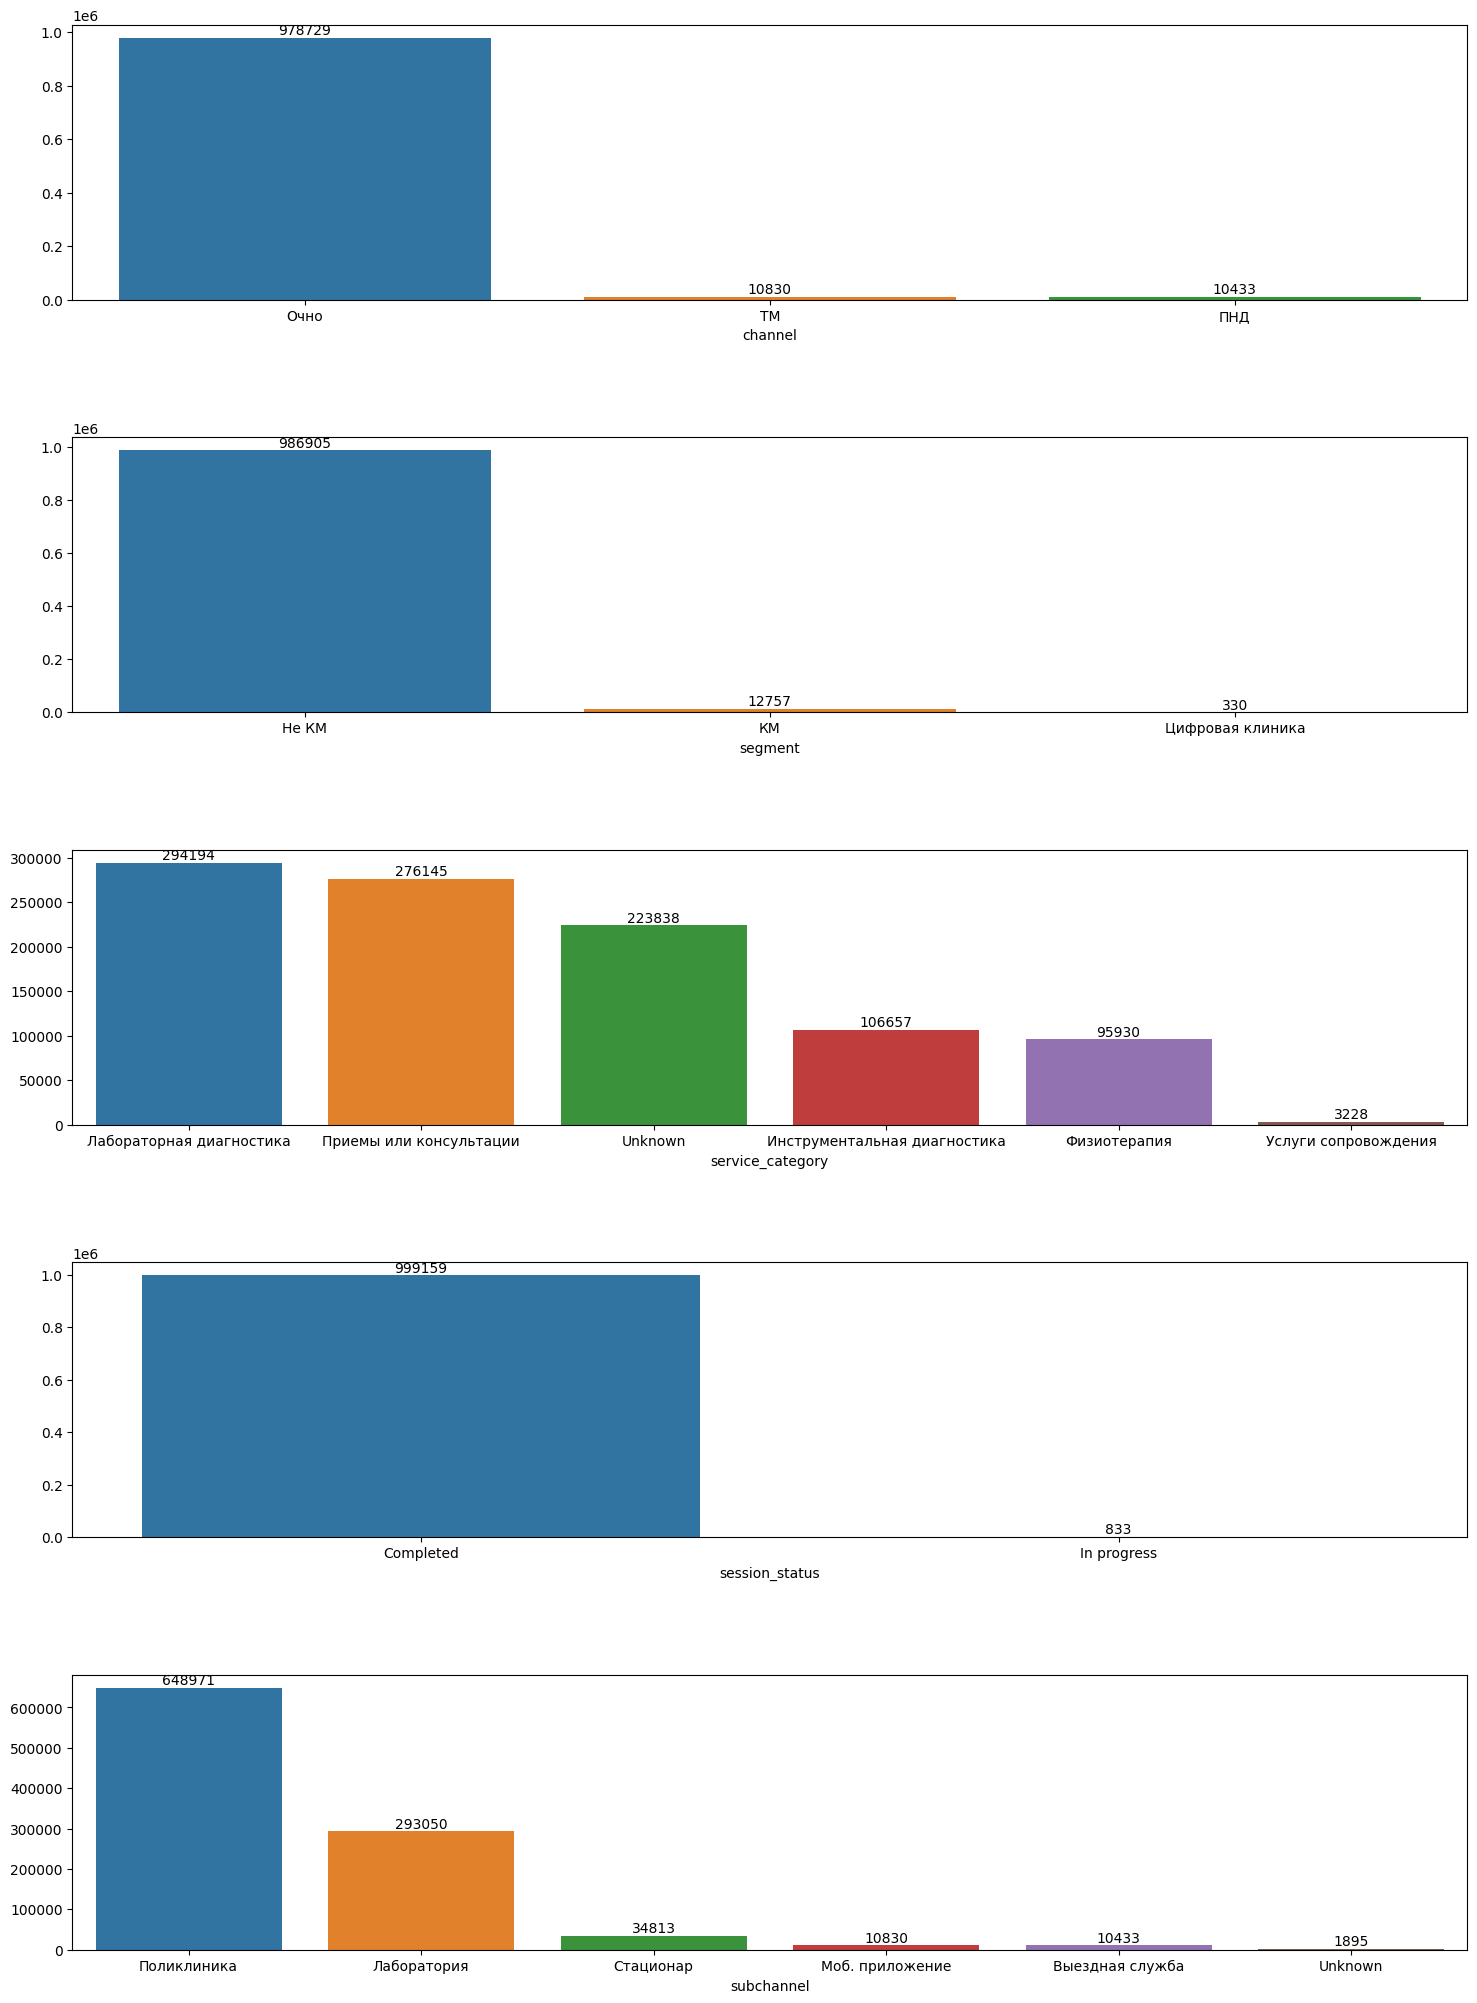

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, figsize=(18, 25))
plt.subplots_adjust(hspace=.5, wspace=.3)

cat_cols = train_df.select_dtypes('object').columns.difference(['session_id','date_service','session_start_date','session_end_date'])
# Построение графиков на каждом subplot
for i, col in enumerate(cat_cols):
    sns.barplot(x=train_df[col].value_counts().index,y=df[col].value_counts().values, ax=axes[i])
    axes[i].bar_label(axes[i].containers[0])
# Отображаем графики
plt.show()

- Больше всего люди обращаются в поликлинику или в лабораторию
- Люди предпочитают ходить очно 
- Большую часть занимают приёмы в лабораторной диагностике или консультации

In [12]:
eda_df = train_df.groupby(['service_category','service_rownum'], as_index=False).agg(mean_sum_rub_service = ('sum_rub_service', 'mean'),
                                                        median_sum_rub_service = ('sum_rub_service', 'median'),
                                                        service_rownum_count = ('service_rownum', 'count'))

eda_df[(eda_df.service_rownum_count > 300) & (eda_df.service_category != "Unknown")].sort_values('service_rownum_count',ascending=False).head(20)

,service_category,service_rownum,mean_sum_rub_service,median_sum_rub_service,service_rownum_count
2660,Приемы или консультации,1,1426.490266,1283.0,50958
2661,Приемы или консультации,2,1394.032306,1235.0,21389
2027,Лабораторная диагностика,3,432.608087,316.0,16371
2028,Лабораторная диагностика,4,409.495930,295.0,15972
2029,Лабораторная диагностика,5,404.064278,286.0,14764
2662,Приемы или консультации,3,1379.651551,1224.0,14510
2026,Лабораторная диагностика,2,499.954054,332.0,14234
2030,Лабораторная диагностика,6,379.491478,276.0,13201
2031,Лабораторная диагностика,7,373.239815,269.0,11905
2663,Приемы или консультации,4,1354.629268,1215.0,11685


Наиболее популярные услуги , которыми пользуются клиенты находятся в категориях `Приемы и консультации` и `Лабороторная диагностика`, где большинство номеров услуг лежат в пределах от [1,10]. Вероятнее всего от них и будет идти основной доход

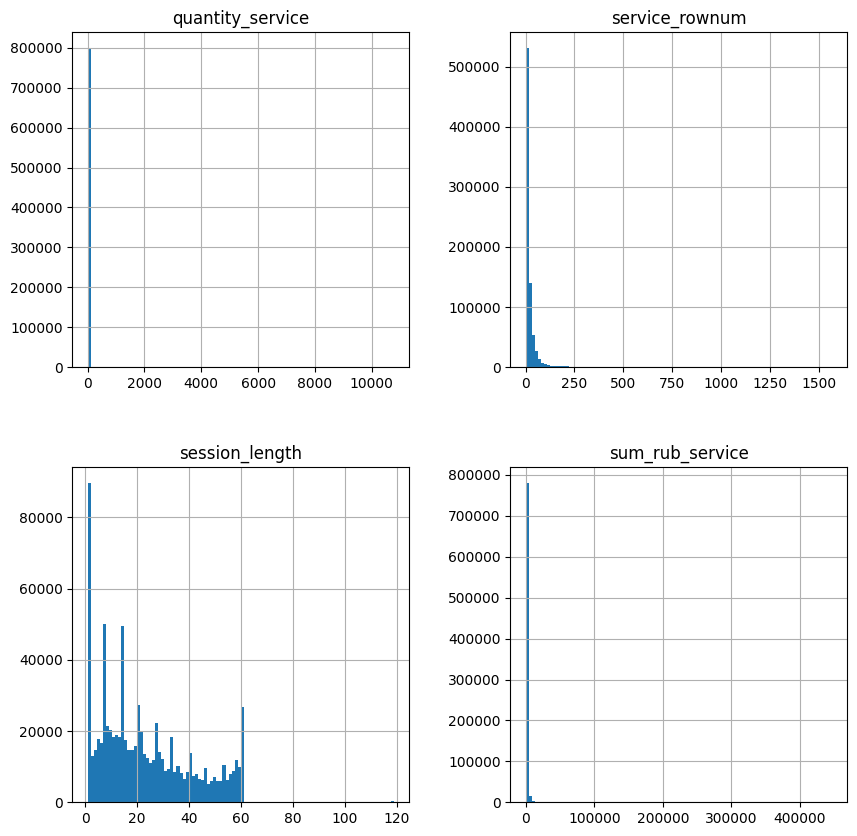

In [13]:
cols_for_boxplots = train_df.select_dtypes(['int','float']).columns.difference(['user_id','hospital_id'])

train_df[cols_for_boxplots].hist(figsize=(10,10),bins=100);

По гистограммам числовых столбцов видно, что где-то спрятались выбросные значения

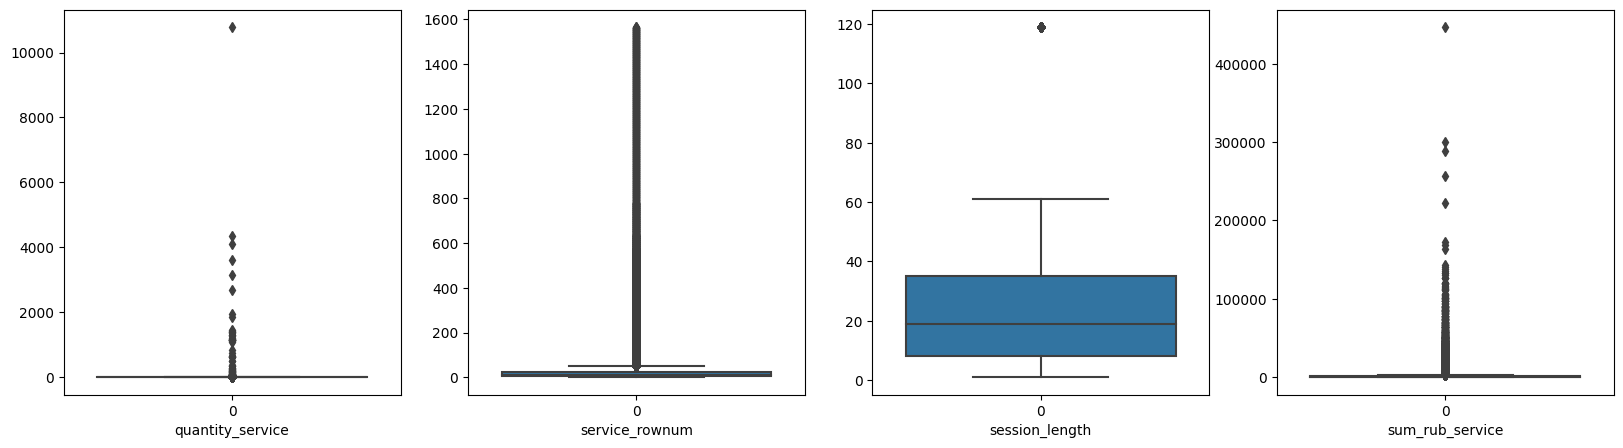

In [14]:
fig, axes = plt.subplots(1,len(cols_for_boxplots), figsize=(20, 5))

for i, col in enumerate(cols_for_boxplots):
    sns.boxplot(train_df[col], ax=axes[i])
    axes[i].set_xlabel(col)
    # plt.xlabel('sas')
plt.show()

Во всех столбцах кроме `session_lenght` присутствует большое кол-во выбросов

In [15]:
# # Удалим строки с выбросами
# for col in cols_for_boxplots:
#     iqr = train_df[col].quantile(.75) - train_df[col].quantile(.25)
#     lower_bound = train_df[col].quantile(.25) - 3*iqr
#     upper_bound = train_df[col].quantile(.75) + 3*iqr

#     train_df = train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]
#     # break

Удаление выбросов плохо сказалось на последующем построении модели. Поэтому принятно решение их оставить, т.к это и не выбросы вовсе 

Построим phik-корреляцию для всего тренировочного датасета:

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


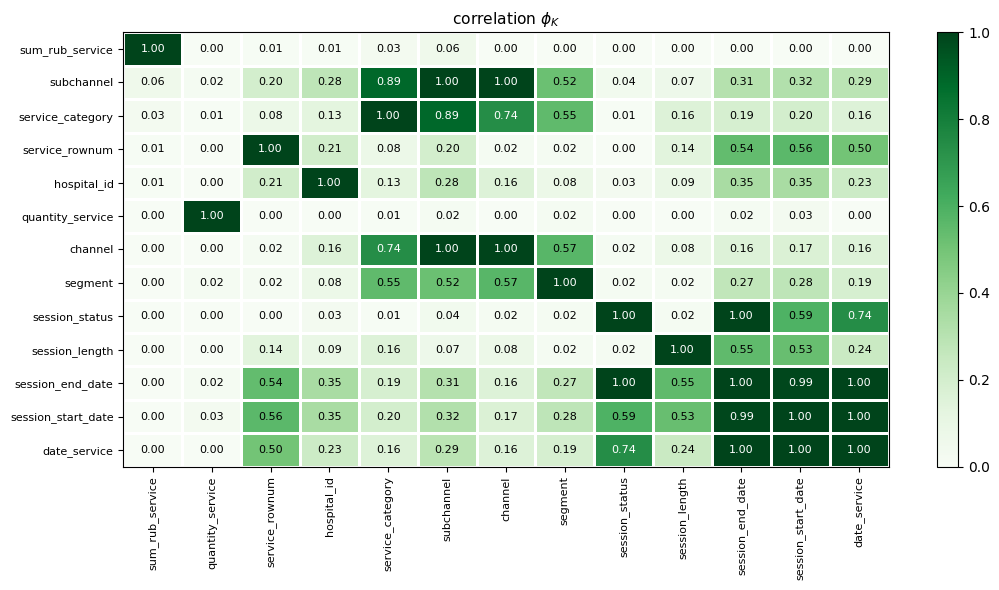

In [16]:
phik_overview = train_df.drop(['session_id','user_id'],axis=1).phik_matrix().round(2).sort_values('sum_rub_service')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))

Построим phik-корреляцию для `десяти` session_id, длина которых больше 40, чтобы увидеть зависимости в последовательности одной сессии. Усредним корреляцию по этим последовательностям

In [17]:
phik_overview = pd.DataFrame(index=["date_service","subchannel","service_category","service_rownum","sum_rub_service"],
                            columns=["date_service","subchannel","service_category","service_rownum","sum_rub_service"]).fillna(0)
n = 0
for id in tqdm(train_df.session_id.value_counts()[train_df.session_id.value_counts() > 40].index):
    
    corr_df = train_df[train_df.session_id == id].drop(['session_id','user_id'],axis=1)
    phik_overview_corr = corr_df.phik_matrix().round(2).sort_values('sum_rub_service').fillna(0)
    if phik_overview_corr.shape == (5,5):
        phik_overview += phik_overview_corr
        n += 1
    if n == 10:
        break
phik_overview = phik_overview/n

  0%|          | 2/3187 [00:00<03:19, 15.96it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  0%|          | 6/3187 [00:00<03:27, 15.30it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  0%|          | 8/3187 [00:00<03:23, 15.64it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  0%|          | 10/3187 [00:00<03:24, 15.53it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  0%|          | 14/3187 [00:01<04:11, 12.60it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  1%|          | 18/3187 [00:01<03:46, 13.99it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  1%|          | 20/3187 [00:01<03:37, 14.54it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  1%|          | 24/3187 [00:01<03:28, 15.15it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  1%|          | 26/3187 [00:01<03:30, 15.03it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  1%|          | 30/3187 [00:02<03:26, 15.28it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  1%|          | 34/3187 [00:02<03:17, 15.93it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  1%|          | 38/3187 [00:02<03:19, 15.81it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  1%|▏         | 40/3187 [00:02<03:17, 15.95it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  1%|▏         | 44/3187 [00:02<03:19, 15.74it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 48/3187 [00:03<03:18, 15.83it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 52/3187 [00:03<03:14, 16.11it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 56/3187 [00:03<03:19, 15.71it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 58/3187 [00:03<03:16, 15.91it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 62/3187 [00:04<03:13, 16.12it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 64/3187 [00:04<03:03, 17.01it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 68/3187 [00:04<03:10, 16.37it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 72/3187 [00:04<03:19, 15.62it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 76/3187 [00:04<03:20, 15.49it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  2%|▏         | 78/3187 [00:05<03:16, 15.83it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  3%|▎         | 82/3187 [00:05<03:16, 15.83it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


  3%|▎         | 84/3187 [00:05<03:22, 15.30it/s]

interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']
interval columns not set, guessing: ['session_length', 'hospital_id', 'service_rownum', 'quantity_service', 'sum_rub_service']


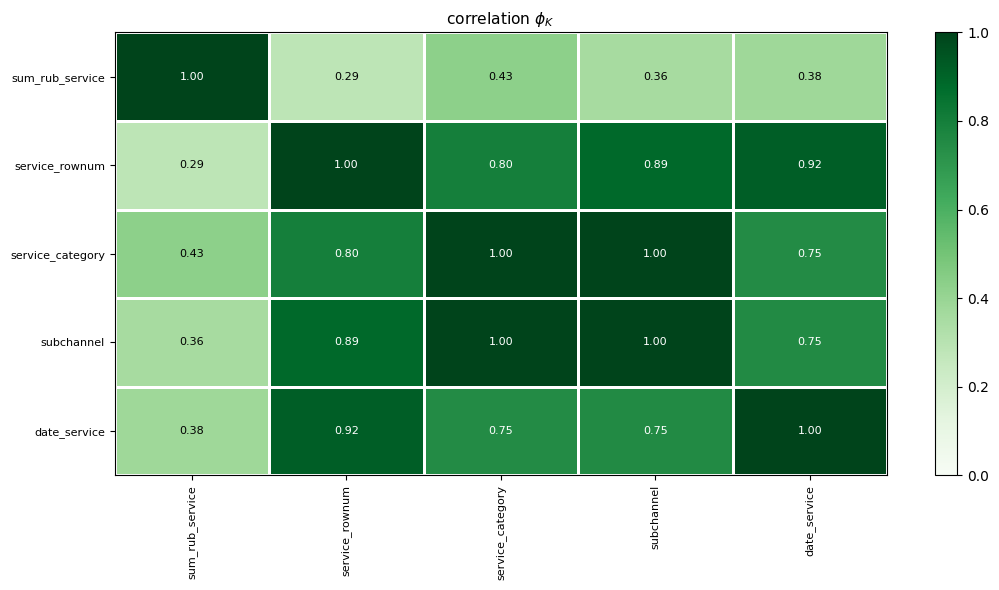

In [18]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))

Существует слабая корреляция с таргетом, от всех признаков

In [19]:
# sns.pairplot(train_df,hue='service_category')


### тут я закоментил, т.к долго строится ###

![Alt text](image-2.png)

На pairplot-е также не видно каких-то строгих зависимостей или доп фичей для генерации. Наибольшее количество длительности сессий сконцентрировано в диапазонах [0, 40] и [50, 60]

## MODELING

In [20]:
def make_fts(df):
    grouped_df = df.groupby(['session_id'],as_index=False).agg(min_date_session = ('session_start_date', 'min'),
                                                max_date_session = ('session_end_date', 'max'),
                                                mean_sessions_length = ('session_length', 'mean'),
                                                mode_session_status = ('session_status', lambda x: pd.Series(x).mode()[0]),
                                                mode_segment = ('segment', lambda x: pd.Series(x).mode()[0]),
                                                mode_channel = ('channel', lambda x: pd.Series(x).mode()[0]),
                                                mode_subchannel = ('subchannel', lambda x: pd.Series(x).mode()[0]),
                                                mode_hospital_id = ('hospital_id', lambda x: pd.Series(x).mode()[0]),
                                                mode_service_rownum = ('service_rownum', 'median'),
                                                sum_quantity_service = ('quantity_service', 'sum'),
                                                mean_quantity_service = ('quantity_service', 'mean'),
                                                median_quantity_service = ('quantity_service', 'median'),
                                                mode_service_category = ('service_category', lambda x: pd.Series(x).mode()[0]),
                                                count_service_category = ('service_category', 'nunique'),
                                                count_service_rownum = ('service_rownum', 'nunique'),
                                                count_subchannel = ('subchannel', 'nunique'),
                                                count_channel = ('channel', 'nunique'),
                                                count_segment = ('segment', 'nunique'),
                                                # seq_rownum = ('service_rownum', lambda x: x.tolist()),
                                                target = ('sum_rub_service', 'mean'),
    )
    grouped_df = grouped_df.merge(df.pivot_table(index='session_id',columns='service_category', aggfunc='count')['channel'].reset_index())
    grouped_df = grouped_df.merge(df.pivot_table(index='session_id',columns='subchannel', aggfunc='count')['channel'].reset_index(),left_index=True, right_index=True)
    grouped_df = grouped_df.fillna(0)
    grouped_df['date_diff'] = (grouped_df.max_date_session - grouped_df.min_date_session).dt.days

    return grouped_df

Сгенерируем фичи с помощью группировки, найдём:
 - Моду
 - Медиану
 - Среднее
 - Количество раз, сколько встретилось `service_category` в `session_id`, как отдельные столбцы
 - Количество раз, сколько встретилось `subchannel` в `session_id`, как отдельные столбцы

In [21]:
train_grouped_df = make_fts(train_df)
test_grouped_df = make_fts(test_df)

In [22]:
cols2drop = ['session_id_x','session_id_y','min_date_session','max_date_session'] # Удалим колонки с датами и айдишниками
cat_features = ['mode_session_status','mode_segment', 'mode_channel', 'mode_subchannel', 'mode_hospital_id','mode_service_category']

train_grouped_df.sample(5)

,session_id_x,min_date_session,max_date_session,mean_sessions_length,mode_session_status,mode_segment,mode_channel,mode_subchannel,mode_hospital_id,mode_service_rownum,sum_quantity_service,mean_quantity_service,median_quantity_service,mode_service_category,count_service_category,count_service_rownum,count_subchannel,count_channel,count_segment,target,Unknown_x,Инструментальная диагностика,Лабораторная диагностика,Приемы или консультации,Услуги сопровождения,Физиотерапия,session_id_y,Unknown_y,Выездная служба,Лаборатория,Моб. приложение,Поликлиника,Стационар,date_diff
31967,139708754.2.1,2022-11-01,2022-11-15,15.0,Completed,Не КМ,Очно,Поликлиника,139002194,9.5,18,1.0,1.0,Физиотерапия,3,18,1,1,1,1296.444444,0.0,2.0,0.0,5.0,0.0,11.0,139708754.2.1,0.0,0.0,0.0,0.0,18.0,0.0,14
7513,136105262.1.1,2022-03-02,2022-03-02,1.0,Completed,Не КМ,Очно,Поликлиника,147598058,1.0,1,1.0,1.0,Приемы или консультации,1,1,1,1,1,1184.000000,0.0,0.0,0.0,1.0,0.0,0.0,136105262.1.1,0.0,0.0,0.0,0.0,1.0,0.0,0
55070,141271830.1.1,2022-03-02,2022-03-02,1.0,Completed,Не КМ,Очно,Поликлиника,142177071,1.0,1,1.0,1.0,Приемы или консультации,1,1,1,1,1,2035.000000,0.0,0.0,0.0,1.0,0.0,0.0,141271830.1.1,0.0,0.0,0.0,0.0,1.0,0.0,0
19816,138144844.2.1,2022-12-02,2022-12-16,15.0,Completed,Не КМ,Очно,Лаборатория,45006337,2.5,4,1.0,1.0,Лабораторная диагностика,2,4,2,1,1,1207.750000,0.0,0.0,2.0,2.0,0.0,0.0,138144844.2.1,0.0,0.0,2.0,0.0,2.0,0.0,14
67558,141798746.5.1,2022-12-20,2022-12-20,1.0,Completed,Не КМ,Очно,Поликлиника,140847619,1.5,2,1.0,1.0,Инструментальная диагностика,2,2,1,1,1,1739.500000,0.0,1.0,0.0,1.0,0.0,0.0,141798746.5.1,0.0,0.0,0.0,0.0,2.0,0.0,0


In [23]:
def make_data_for_cb(train_df, test_df, cols2drop):
    X_train = train_df.drop(cols2drop + ["target"], axis=1)
    y_train = train_df["target"]

    X_test = test_df.drop(cols2drop + ["target"], axis=1)
    y_test = test_df["target"]
    return X_train, X_test, y_train, y_test

Создадим функцию для препроцессинга данных перед подачей в CatBoost

In [24]:
def make_data_for_sklearn(train_df, test_df, cols2drop, cat_features):
    enc = OneHotEncoder(sparse_output=False,drop='first', handle_unknown='ignore')
    enc.fit(train_df[cat_features])
    temp_train_df = train_df.merge(pd.DataFrame(enc.transform(train_df[cat_features]), columns=enc.get_feature_names_out())
                              ,left_index=True,right_index=True).drop(cols2drop+cat_features,axis=1)
    temp_test_df = test_df.merge(pd.DataFrame(enc.transform(test_df[cat_features]), columns=enc.get_feature_names_out())
                              ,left_index=True,right_index=True).drop(cols2drop+cat_features,axis=1)
    
    X_train = temp_train_df.drop(["target"], axis=1)
    y_train = temp_train_df["target"]

    X_test = temp_test_df.drop(["target"], axis=1)
    y_test = temp_test_df["target"]

    
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
    X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())
    return X_train, X_test, y_train, y_test

Создадим функцию для препроцессинга данных перед подачей в Sklearn-модели

In [25]:
def make_k_fold_model(X, X_test, y, y_test, model_name, cat_features):
    N_FOLDS = 5
    kfold = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
    oof_preds = 0
    perm_importances = 0

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train = X.loc[train_idx]
        X_val = X.loc[val_idx]

        y_train = y.loc[train_idx]
        y_val = y.loc[val_idx]

        if model_name == 'catboost':
            model = CatBoostRegressor(random_seed=42, early_stopping_rounds=50, cat_features=cat_features, learning_rate=0.05, n_estimators=2000,
                                      eval_metric='MAE', verbose=False)
            model.fit(X_train, y_train, eval_set=(X_val, y_val))
            perm_importances += permutation_importance(
                model, X_test, y_test, n_repeats=2, random_state=42).importances_mean

        else:
            model = Ridge()
            model.fit(X_train, y_train)
        pred = model.predict(X_test)
        oof_preds += pred/N_FOLDS
        print(f'Фолд {fold}')
        print(f"MAE: {mean_absolute_error(y_test, pred)}")

    print('-'*100)
    print('Финальный прогноз:')
    print(f"MAE: {mean_absolute_error(y_test, oof_preds)}")
    if model_name == 'catboost':
        sorted_idx = perm_importances.argsort()
        fig = plt.figure(figsize=(12, 6))
        plt.barh(range(len(sorted_idx)),
                 perm_importances[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(
            X_train.columns)[sorted_idx])
        plt.title('Permutation Importance')

    return oof_preds
    # break

Данная функция делает предикты на тесте с помощью кросс-валидации, считая внутри при этом метрику `MAE` на каждом фолде. И усредняя предикты на тесте.
Для CatBoost-a реализован усредненный `permutation_importances` и выведен график с важностью фичей. 

In [26]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = make_data_for_cb(train_grouped_df, test_grouped_df, cols2drop)
X_train_sk, X_test_sk, y_train_sk, y_test_sk = make_data_for_sklearn(train_grouped_df, test_grouped_df, cols2drop, cat_features)

## Рекурсивный feature selection

Посмотрим на корреляцию после группировки:

interval columns not set, guessing: ['mean_sessions_length', 'mode_hospital_id', 'mode_service_rownum', 'sum_quantity_service', 'mean_quantity_service', 'median_quantity_service', 'count_service_category', 'count_service_rownum', 'count_subchannel', 'count_channel', 'count_segment', 'target', 'Unknown_x', 'Инструментальная диагностика', 'Лабораторная диагностика', 'Приемы или консультации', 'Услуги сопровождения', 'Физиотерапия', 'Unknown_y', 'Выездная служба', 'Лаборатория', 'Моб. приложение', 'Поликлиника', 'Стационар', 'date_diff']


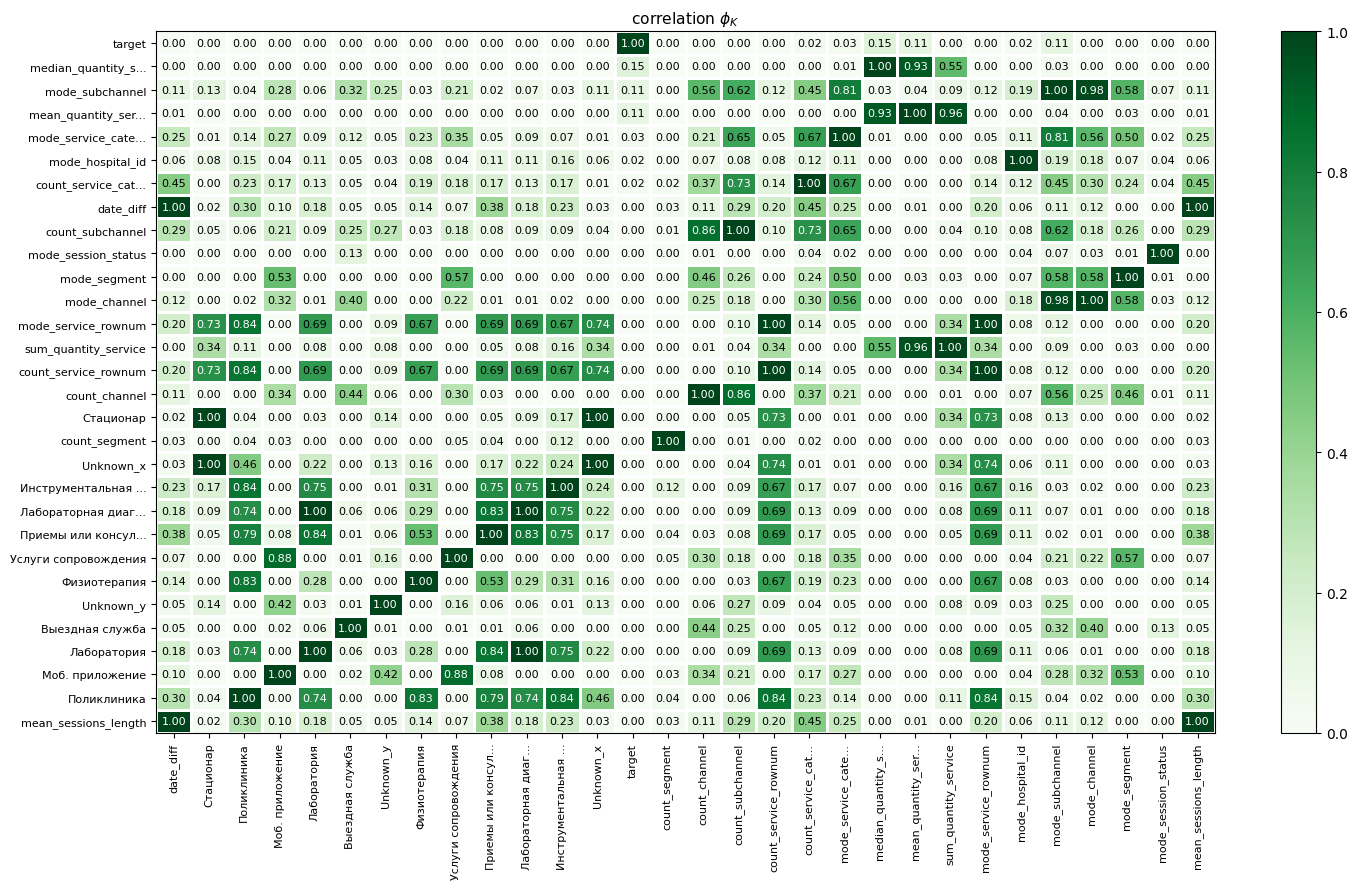

In [27]:
phik_overview = train_grouped_df.drop(cols2drop, axis=1).phik_matrix().round(2).sort_values('target')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(15, 9))

С целевым признаком и с количеством услуг почти ничего не коррелирует. Воспользуемся рекурсивным методом отбора признаков, чтобы избежать мультиколлинеарности

In [28]:
model = CatBoostRegressor(random_seed=42, early_stopping_rounds=50, cat_features=cat_features, learning_rate=0.05, n_estimators=100,
                          eval_metric='MAE', verbose=False)
summary = model.select_features(X_train_cb, y_train_cb,
                                eval_set=(X_test_cb, y_test_cb),
                                features_for_select='0-28',
                                num_features_to_select=23,
                                steps=1,
                                train_final_model=True,
                                logging_level='Silent')

summary['eliminated_features_names']

['count_service_category',
 'mode_session_status',
 'mode_segment',
 'count_subchannel',
 'count_channel',
 'count_segment']

Рекурсивный метод отбора признаков, не дал улучшения метрики на валидации, поэтому оставим исходные фичи, как есть

Фолд 0
MAE: 405.0538429128554
Фолд 1
MAE: 401.37795916696854
Фолд 2
MAE: 413.1102105330009
Фолд 3
MAE: 409.9878854507738
Фолд 4
MAE: 407.4836357641207
----------------------------------------------------------------------------------------------------
Финальный прогноз:
MAE: 398.6460505175546


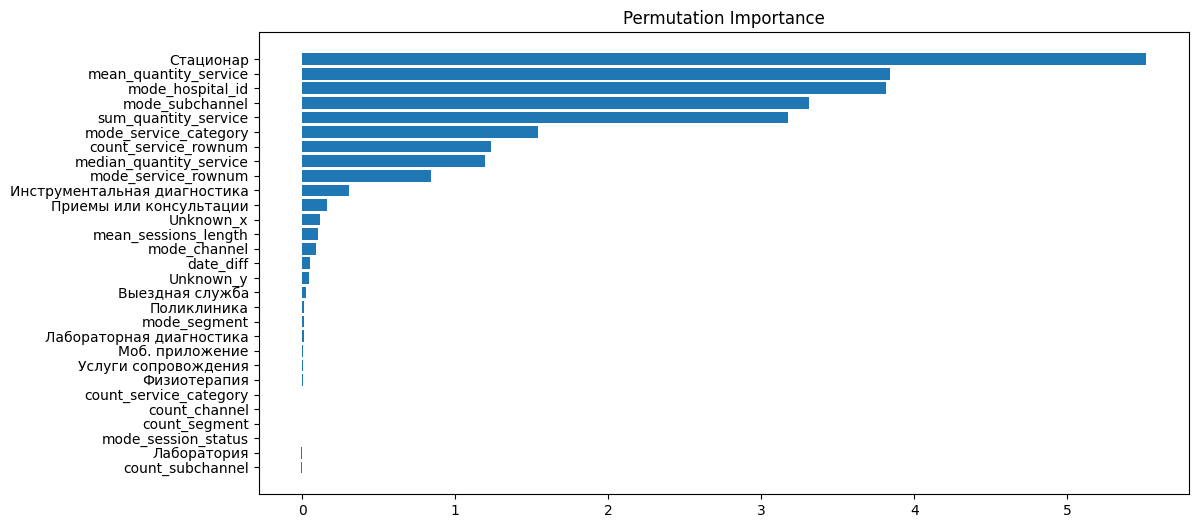

In [29]:
preds = make_k_fold_model(X_train_cb, X_test_cb,
                          y_train_cb, y_test_cb, 'catboost', cat_features)

Наиболее важные признаки, которая модель использует при обучении:
 - Среднее кол-во услуг
 - id больницы
 - Субканал оказания услуги
 - Категория услуги
 - id услуги

 Но для более объективной оценки необходимо использовать совокупность методов: `SHAP`,`Object importance`, `Correaltion Matrix`, `RFE`

## Общий вывод:

`Для бизнеса предусмотрено две модели в зависимости от того, что он требует:`
 - CatBoost, если нам важно качество модели больше, чем её интерпритация
 - Ridge - линейная интерпретируемая модель

`Был проведён EDA, в ходе которого не было выявлено каких-либо чётких корреляционных зависимостей с средней суммой оплаты за сессию и средним кол-вом услуг за сессию.`

`Что можно улучшить:`
 - Изменить подход к задаче и попробовать решить её как рекомендационную систему
 - Попробовать представить последовательность действий пользователь в виде некоторого эмбеддинга и сделать этот эмбеддинг как дополнительную "фичу"
 - На pairplot-ах также не было четких зависимостей с таргетом. Но в качестве доп фичи, можно попробовать слепую генерацию признаков. Возвести числовые фичи в квадрат, куб, логарифм, корень и тд. Данный подход также может улучшить качество
 - Подобрать гиперпараметры оптуной
 - Попробовать SHAP-values для анализа влияния признаков
 - Понизить размерность PCA, t-SNE, UMAP. Возможно улучшит качество